<a href="https://colab.research.google.com/github/danielrjakab1/bdb_reaccuracy/blob/main/Reaccuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
# mount drive to access .csv files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:

base_path = '/content/drive/Shareddrives/BDB Reacuuracy/cleaned_data/'
inputs = [pd.read_csv(f'{base_path}cleaned_input_w{str(i).zfill(2)}.csv') for i in range(1, 17)]
inputs_dict = {f'w{str(i).zfill(2)}': df for i, df in enumerate(inputs, start=1)}


In [ ]:
base_path = '/content/drive/Shareddrives/BDB Reacuuracy/train/'
outputs = [pd.read_csv(f'{base_path}output_2023_w{str(i).zfill(2)}.csv') for i in range(1, 18)]
outputs_dict = {f'w{str(i).zfill(2)}': df for i, df in enumerate(outputs, start=1)}

In [ ]:
for week, df in inputs_dict.items():
    print(f'{week} input columns:', list(df.columns))
for week, df in outputs_dict.items():
    print(f'{week} output columns:', list(df.columns))


w01 input columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'pass_result', 'team_coverage_man_zone']
w02 input columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'pass_result', 'team_coverage_man_zone']
w03 input columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x

In [ ]:
position_counts = pd.concat([df['play_id'] for df in inputs_dict.values()]).value_counts()
position_counts

,count
play_id,
55,6539
102,3309
77,3087
1933,2476
56,2234
...,...
4039,68
4422,65
4490,54


In [ ]:
play_player_counts = pd.concat([df[['game_id', 'play_id', 'player_name']] for df in inputs_dict.values()]) \
                        .drop_duplicates() \
                        .groupby(['game_id', 'play_id'])['player_name'] \
                        .nunique() \
                        .reset_index(name='unique_player_count')
play_player_counts


,game_id,play_id,unique_player_count
0,2023090700,101,5
1,2023090700,194,7
2,2023090700,219,7
3,2023090700,361,5
4,2023090700,436,6
...,...,...,...
12543,2023122502,4190,7
12544,2023122502,4213,7
12545,2023122502,4238,7
12546,2023122502,4263,7


In [ ]:
merged_all = pd.concat([
    pd.merge(inputs_dict[f'w{str(i).zfill(2)}'], outputs_dict[f'w{str(i).zfill(2)}'],
              on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
              suffixes=('_in', '_out'))
    for i in range(1, 17)
], ignore_index=True)

In [ ]:
height_parts = merged_all['player_height'].astype(str).str.extract(r'(\d+)-(\d+)')
feet = pd.to_numeric(height_parts[0], errors='coerce')
inches = pd.to_numeric(height_parts[1], errors='coerce')
merged_all['player_height'] = (feet * 12 + inches).astype(float)
merged_all['player_weight'] = pd.to_numeric(merged_all['player_weight'], errors='coerce')
merged_all['absolute_yardline_number'] = pd.to_numeric(merged_all['absolute_yardline_number'], errors='coerce')

In [ ]:
merged_all['tackled'] = ((abs(merged_all['x_out'] - merged_all['ball_land_x']) < 1.0) &
                         (abs(merged_all['y_out'] - merged_all['ball_land_y']) < 1.0)).astype(int)

In [ ]:
feature_cols = [
    'absolute_yardline_number', 'player_height', 'player_weight',
    'x_in', 'y_in', 's', 'a', 'dir', 'o', 'ball_land_x', 'ball_land_y'
]
X = merged_all[feature_cols]
y = merged_all['tackled']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc'
)

model.fit(X_train, y_train)
print('AUC:', roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

AUC: 0.8599086772525261


In [ ]:
numeric_cols = ['player_height', 'player_weight', 's', 'a', 'o']
context_cols = ['game_id', 'play_id', 'player_to_predict', 'absolute_yardline_number',
                'x_in', 'y_in', 'dir', 'ball_land_x', 'ball_land_y']
avg_player_features = merged_all[numeric_cols].mean().to_dict()
df_avg_player = merged_all[context_cols].copy()
for col, val in avg_player_features.items():
    df_avg_player[col] = val
df_avg_player['expected_tackle_prob'] = model.predict_proba(df_avg_player[X.columns])[:,1]
expected_per_play_player = df_avg_player.groupby(['game_id','play_id','player_to_predict'])['expected_tackle_prob'].mean().reset_index()
expected_per_play_player



,game_id,play_id,player_to_predict,expected_tackle_prob
0,2023090700,101,True,0.000252
1,2023090700,194,True,0.007095
2,2023090700,219,True,0.008540
3,2023090700,361,True,0.002297
4,2023090700,436,True,0.011548
...,...,...,...,...
11505,2023122502,4190,True,0.004822
11506,2023122502,4213,True,0.007704
11507,2023122502,4238,True,0.008123
11508,2023122502,4263,True,0.015264


In [ ]:
expected_per_play_player['player_to_predict'].unique()

array([ True])

In [ ]:
merged_all['expected_prob'] = model.predict_proba(merged_all[X.columns])[:,1]

player_summary = (
    merged_all.groupby('player_name')
    .agg(
        plays=('tackled', 'count'),
        expected_tackles=('expected_prob', 'sum'),
        actual_tackles=('tackled', 'sum')
    )
    .reset_index()
)

player_summary['tackles_over_expected'] = (
    player_summary['actual_tackles'] - player_summary['expected_tackles']
)

player_summary

,player_name,plays,expected_tackles,actual_tackles,tackles_over_expected
0,A.J. Terrell,1615,20.461397,12,-8.461397
1,AJ Finley,45,0.189849,0,-0.189849
2,Adoree' Jackson,1146,9.020630,10,0.979370
3,Adrian Amos,580,2.603140,1,-1.603140
4,Adrian Phillips,230,0.741350,0,-0.741350
...,...,...,...,...,...
583,Zach Cunningham,1220,8.012057,17,8.987943
584,Zack Baun,104,0.712439,1,0.287561
585,Zaire Franklin,1272,7.606511,4,-3.606511
586,Zaven Collins,257,0.923683,2,1.076317


In [ ]:
player_summary_sorted = player_summary.sort_values(by='tackles_over_expected', ascending=False)
player_summary_sorted.head()

,player_name,plays,expected_tackles,actual_tackles,tackles_over_expected
372,Kyle Dugger,1459,10.625395,29,18.374605
20,Amik Robertson,1060,11.320018,26,14.679982
52,Bobby Okereke,949,7.865131,22,14.134869
469,Paulson Adebo,1687,25.733320,39,13.266680
384,Logan Wilson,1461,11.256797,23,11.743203


In [ ]:
bobby_okereke_tackles = merged_all[(merged_all['player_name'] == 'Bobby Okereke') & (merged_all['tackled'] == 1)]
bobby_okereke_tackles.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,o,num_frames_output,ball_land_x,ball_land_y,pass_result,team_coverage_man_zone,x_out,y_out,tackled,expected_prob
100065,2023100804,1755,True,47872,6,left,14,Bobby Okereke,NaN,234,...,95.61,7,10.700000,20.26,IN,ZONE_COVERAGE,10.20,21.14,1,0.018420
100066,2023100804,1755,True,47872,7,left,14,Bobby Okereke,NaN,234,...,95.61,7,10.700000,20.26,IN,ZONE_COVERAGE,10.28,20.58,1,0.032837
100407,2023100804,2585,True,47872,12,left,83,Bobby Okereke,NaN,234,...,108.44,13,80.570000,12.73,IN,ZONE_COVERAGE,80.58,13.43,1,0.003797
100408,2023100804,2585,True,47872,13,left,83,Bobby Okereke,NaN,234,...,108.44,13,80.570000,12.73,IN,ZONE_COVERAGE,80.89,12.96,1,0.003629
132271,2023101512,2108,True,47872,7,right,64,Bobby Okereke,NaN,234,...,270.96,8,73.129997,22.32,IN,ZONE_COVERAGE,72.95,21.53,1,0.006732


In [ ]:
unique_plays = bobby_okereke_tackles[['game_id', 'play_id']].drop_duplicates()
selected_game_id = unique_plays.iloc[0]['game_id']
selected_play_id = unique_plays.iloc[0]['play_id']

print(f"Selected Game ID: {selected_game_id}")
print(f"Selected Play ID: {selected_play_id}")

Selected Game ID: 2023100804
Selected Play ID: 1755


In [ ]:
play_tracking_data = merged_all[
    (merged_all['game_id'] == selected_game_id) &
    (merged_all['play_id'] == selected_play_id)
][['frame_id', 'nfl_id', 'player_name', 'x_in', 'y_in', 'x_out', 'y_out', 'ball_land_x', 'ball_land_y']]

play_tracking_data.head()

,frame_id,nfl_id,player_name,x_in,y_in,x_out,y_out,ball_land_x,ball_land_y
100060,1,47872,Bobby Okereke,10.02,27.49,10.08,23.74,10.7,20.26
100061,2,47872,Bobby Okereke,10.04,27.50,10.08,23.27,10.7,20.26
100062,3,47872,Bobby Okereke,10.04,27.50,10.09,22.77,10.7,20.26
100063,4,47872,Bobby Okereke,10.06,27.49,10.11,22.25,10.7,20.26
100064,5,47872,Bobby Okereke,10.09,27.42,10.15,21.70,10.7,20.26


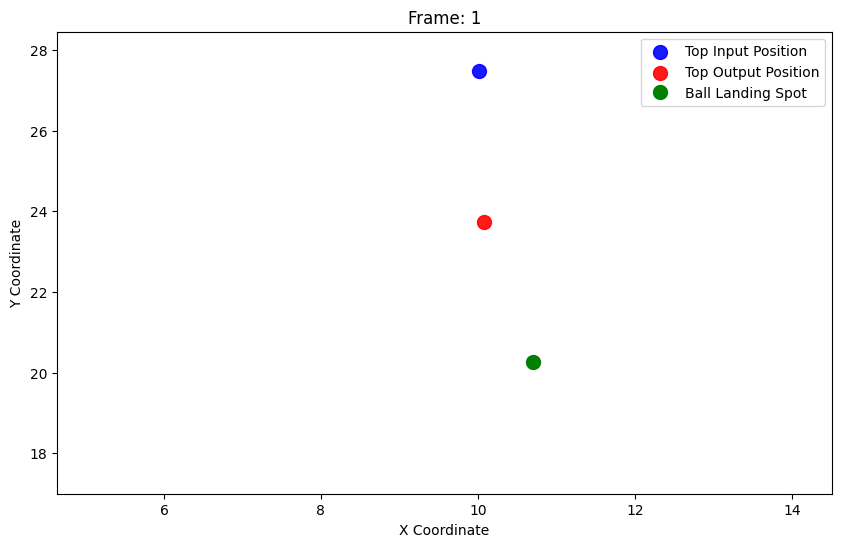

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

# Create a figure and an axes object for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate global min/max for x and y for dynamic limits
all_x = pd.concat([play_tracking_data['x_in'], play_tracking_data['x_out'], play_tracking_data['ball_land_x']]).dropna()
all_y = pd.concat([play_tracking_data['y_in'], play_tracking_data['y_out'], play_tracking_data['ball_land_y']]).dropna()

min_x, max_x = all_x.min(), all_x.max()
min_y, max_y = all_y.min(), all_y.max()

# Add a small padding to the limits
x_padding = (max_x - min_x) * 0.1
y_padding = (max_y - min_y) * 0.1

plot_xlim = (min_x - x_padding, max_x + x_padding)
plot_ylim = (min_y - y_padding, max_y + y_padding)

def update(frame):
    ax.clear()  # Clear the current axes content
    current_frame_data = play_tracking_data[play_tracking_data['frame_id'] == frame]

    # Plot only the 'top dot' for input position (highest y_in)
    if not current_frame_data.empty and not current_frame_data['y_in'].isnull().all():
        top_input_player = current_frame_data.loc[current_frame_data['y_in'].idxmax()]
        ax.scatter(top_input_player['x_in'], top_input_player['y_in'], color='blue', label='Top Input Position', alpha=0.9, s=100)

    # Plot only the 'top dot' for output position (highest y_out)
    if not current_frame_data.empty and not current_frame_data['y_out'].isnull().all():
        top_output_player = current_frame_data.loc[current_frame_data['y_out'].idxmax()]
        ax.scatter(top_output_player['x_out'], top_output_player['y_out'], color='red', label='Top Output Position', alpha=0.9, s=100)

    # Plot the ball landing spot
    if not current_frame_data.empty:
        ball_x = current_frame_data['ball_land_x'].iloc[0]
        ball_y = current_frame_data['ball_land_y'].iloc[0]
        ax.plot(ball_x, ball_y, 'o', color='green', markersize=10, label='Ball Landing Spot')

    # Set dynamic plot limits
    ax.set_xlim(plot_xlim)
    ax.set_ylim(plot_ylim)
    ax.set_title(f'Frame: {frame}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.legend(loc='upper right')

    # Return the plot elements that were modified
    return ax.collections

# Get the range of frame_ids for the animation
frames = play_tracking_data['frame_id'].unique()
frames.sort()

# Create the animation
animation_interval = 200 # Milliseconds per frame
animation_frames = list(frames)

anim = animation.FuncAnimation(fig, update, frames=animation_frames, blit=False, interval=animation_interval)

# Display the animation
HTML(anim.to_jshtml())

In [ ]:
from matplotlib.animation import FFMpegWriter


Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)


anim.save('bobby_okereke_tackle_animation.mp4', writer=writer)

print("Animation saved as 'bobby_okereke_tackle_animation.mp4'")

In [ ]:
    from google.colab import files


    files.download('bobby_okereke_tackle_animation.mp4')

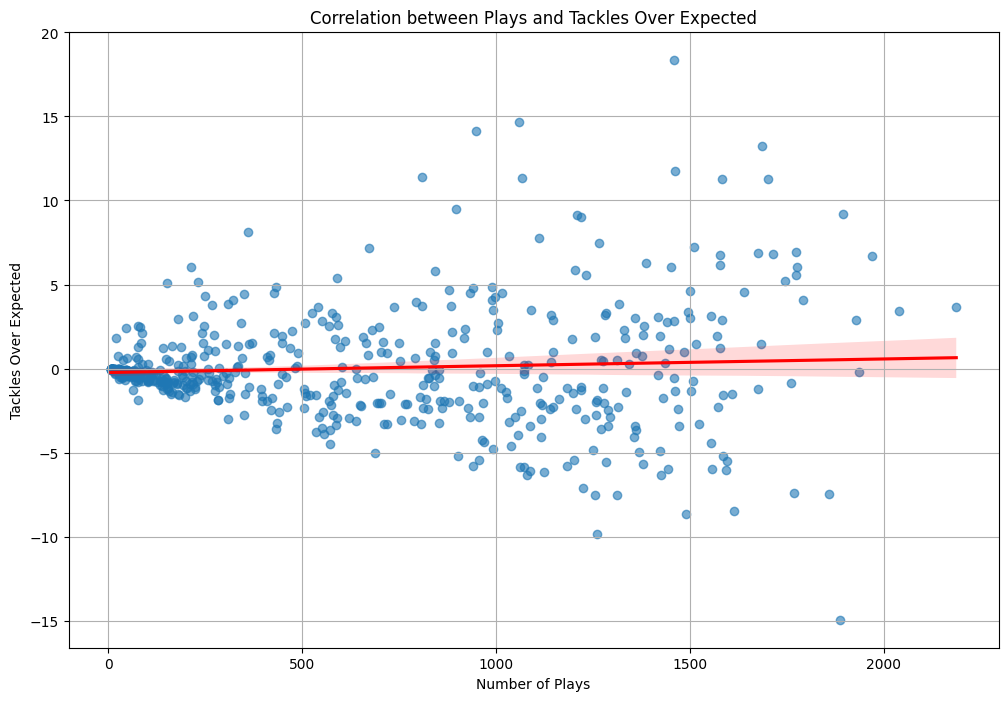

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.regplot(data=player_summary, x='plays', y='tackles_over_expected', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation between Plays and Tackles Over Expected')
plt.xlabel('Number of Plays')
plt.ylabel('Tackles Over Expected')
plt.grid(True)
plt.show()

In [ ]:
pip install shap

In [ ]:
import shap
import matplotlib.pyplot as plt
print("SHAP and Matplotlib imported successfully.")

SHAP and Matplotlib imported successfully.


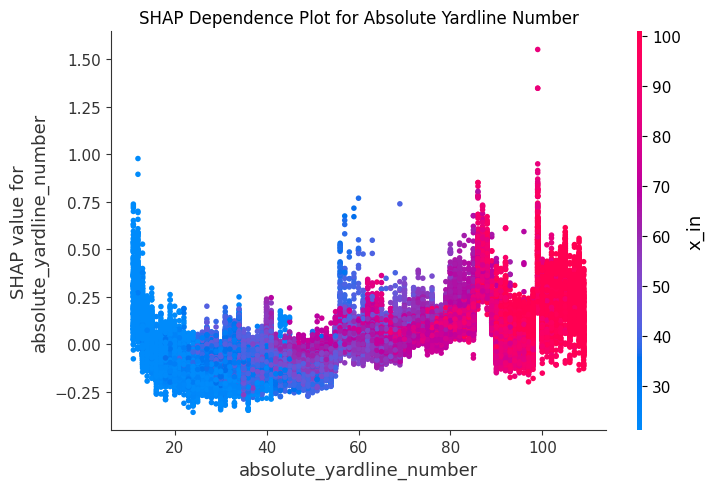

SHAP dependence plot for 'absolute_yardline_number' generated successfully.


In [ ]:
shap.dependence_plot('absolute_yardline_number', shap_values, X_test, show=False)
plt.title('SHAP Dependence Plot for Absolute Yardline Number')
plt.tight_layout()
plt.show()

print("SHAP dependence plot for 'absolute_yardline_number' generated successfully.")